# Analyse du marché de l'emploi au Cameroun

## I. Importation des bibliothèques, fichier excel et traduction

In [1]:
# Importation des bibliothèques
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from deep_translator import GoogleTranslator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importation du fichier csv
df = pd.read_excel ("emplois_prenettoyé.xlsx")
df

,Date de publication,Date limite,Localisation,Titre du poste,Entreprise,Secteur d'activité,Type de contrat,Formation,Expérience,Compétences
0,2024-06-15 00:00:00,30/06/2024,Yaoundé,Delivery Officer,Kaeyros Analytics,Informatique,CDI,BTS en Informatique,0.0,NaN
1,2024-06-09 00:00:00,24/06/2024,Cameroun,COMMERCIAL,Prudential Beneficial,"Administration, Comptabilité, Vente,Gestion",CDD,Bac,0.0,Offre disponible aux personnes majeures
2,2024-06-19 17:00:00,04/07/2024 17:00,Douala,PERSONAL ASSISTANT - EXECUTIVE,Teja Farm,"Administration, Comptabilité, Vente,Gestion",CDI,BTS en Gestion,5.0,NaN
3,2024-06-19 00:00:00,04/07/2024,Douala,Commercial H/F,Areko Group,"Administration, Comptabilité, Vente,Gestion",CDI,Bac ou une formation professionnelle en Commer...,2.0,; Excellentes qualités relationnelles et capac...
4,2024-07-07 00:00:00,22/07/2024,Douala,COMMERCIAL,Proximity Care Sarl,"Administration, Comptabilité, Vente,Gestion",CDI,"BTS en Action Commerciale, Marketing, commerce...",2.0,·; Avoir une expérience minimum de dans le do...
...,...,...,...,...,...,...,...,...,...,...
1128,2024-06-19 00:00:00,2024-06-29 00:00:00,Yaoundé,Stagiaire Support Technique Applicatif - Yaoundé,ADVENT SOFT,Services,Stage,BTS,0.0,NaN
1129,2024-06-19 00:00:00,2024-06-29 00:00:00,Yaoundé,Développeur Full Stack Java/Spring/Angular,ADVENT SOFT,Services,CDD,Licence,5.0,"La modélisation, le développement Back-end de..."
1130,2024-06-18 00:00:00,2024-06-28 00:00:00,Cameroun,Commercial - Douala,AMARAL CONSULTING,Services,Freelance,Bac,0.0,. Objectif par semaine : 01 vente minimum.
1131,2024-06-18 00:00:00,2024-06-28 00:00:00,Cameroun,QA Engineer,RODEC,Services,CDI,Licence,5.0,"A detail oriented, organized . Working close..."


In [3]:
df['Compétences'].head(10)

0                                                  NaN
1             Offre disponible aux personnes majeures 
2                                                  NaN
3    ; Excellentes qualités relationnelles et capac...
4    ·; Avoir une expérience minimum de  dans le do...
5                                                  NaN
6    Une expérience dans une institution bancaire s...
7     Expérience professionnelle souhaitée dans le ...
8     Excellente maitrise du Français à l’écrit et ...
9                                                  NaN
Name: Compétences, dtype: object

In [4]:
# Initialisation du traducteur
#translator = GoogleTranslator (source = 'auto', target = 'fr')

In [5]:
# Traduction de la colonne "Compétences" en français
#df["Compétences_traduites"] = df["Compétences"].dropna().apply(translator.translate).apply(getattr, args=('text',))

In [6]:
# Traduction de la colonne "Titre du poste" en français
#df["Titre du poste_traduites"] = df["Titre du poste"].dropna().apply(translator.translate).apply(getattr, args=('text',))

## II. Analyse exploratoire des données et nettoyage

In [7]:
# Exploration des données
df.describe ()

,Expérience
count,1133.000000
mean,2.311342
std,2.496152
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,15.000000


In [8]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date de publication   1133 non-null   object 
 1   Date limite           1133 non-null   object 
 2   Localisation          1133 non-null   object 
 3   Titre du poste        1133 non-null   object 
 4   Entreprise            1133 non-null   object 
 5   Secteur d'activité    1133 non-null   object 
 6   Type de contrat       1133 non-null   object 
 7   Formation             1133 non-null   object 
 8   Expérience            1133 non-null   float64
 9   Compétences           858 non-null    object 
dtypes: float64(1), object(9)
memory usage: 88.6+ KB


In [9]:
df.dtypes

Date de publication      object
Date limite              object
Localisation             object
Titre du poste           object
Entreprise               object
Secteur d'activité       object
Type de contrat          object
Formation                object
Expérience              float64
Compétences              object
dtype: object

In [10]:
# Vérification des valeurs manquantes par colonnes
df.isnull().sum()

Date de publication       0
Date limite               0
Localisation              0
Titre du poste            0
Entreprise                0
Secteur d'activité        0
Type de contrat           0
Formation                 0
Expérience                0
Compétences             275
dtype: int64

In [11]:
# Remplacer les valeurs manquantes de "Compétences"
df["Compétences"].fillna("Aucune", inplace = True)

In [12]:
# Vérification des valeurs manquantes par colonnes
df.isnull().sum()

Date de publication     0
Date limite             0
Localisation            0
Titre du poste          0
Entreprise              0
Secteur d'activité      0
Type de contrat         0
Formation               0
Expérience              0
Compétences             0
dtype: int64

In [13]:
# Vérification des valeurs dupliquées par colonnes
df.duplicated

<bound method DataFrame.duplicated of      Date de publication           Date limite Localisation  \
0     2024-06-15 00:00:00           30/06/2024      Yaoundé   
1     2024-06-09 00:00:00           24/06/2024     Cameroun   
2     2024-06-19 17:00:00     04/07/2024 17:00       Douala   
3     2024-06-19 00:00:00           04/07/2024       Douala   
4     2024-07-07 00:00:00           22/07/2024       Douala   
...                   ...                  ...          ...   
1128  2024-06-19 00:00:00  2024-06-29 00:00:00      Yaoundé   
1129  2024-06-19 00:00:00  2024-06-29 00:00:00      Yaoundé   
1130  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   
1131  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   
1132  2024-06-18 00:00:00  2024-06-28 00:00:00     Cameroun   

                                        Titre du poste  \
0                                     Delivery Officer   
1                                           COMMERCIAL   
2                       PERSONA

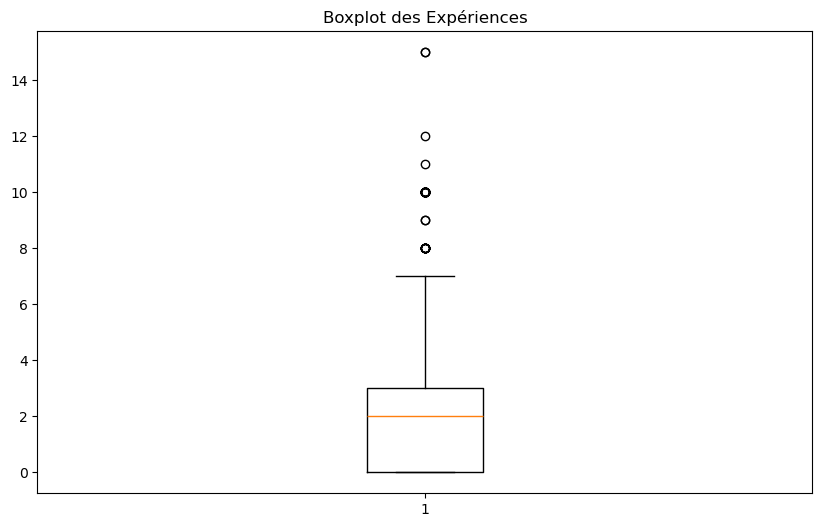

les valeurs aberrantes des expériences sont :      Date de publication        Date limite  Localisation  \
26    2024-06-08 17:00:00  23/06/2024 17:00       Yaoundé   
32    2024-06-05 23:59:00  20/06/2024 23:59       Yaoundé   
69    2024-05-31 17:00:00  15/06/2024 17:00      Cameroun   
83    2024-06-04 17:00:00  19/06/2024 17:00       Yaoundé   
98    2024-05-26 17:00:00  10/06/2024 17:00        Douala   
110   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
111   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
112   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
113   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
114   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
115   2024-05-15 17:00:00  30/05/2024 17:00      Cameroun   
116   2024-05-26 17:00:00  10/06/2024 17:00      Cameroun   
148   2024-05-15 17:00:00  30/05/2024 17:00        Douala   
185   2024-05-15 17:00:00  30/05/2024 17:00       Yaoundé   
187   2024-05-08 17:00:00  23/05/2024 1

In [14]:
# Vérification de valeurs aberrantes par colonnes
# Colonne des expériences
plt.figure (figsize = (10,6))
plt.boxplot(df['Expérience'])
plt.title("Boxplot des Expériences")
plt.show ()
Q1 = df["Expérience"].quantile(0.25)
Q3 = df["Expérience"].quantile(0.75)
IQR = Q3 - Q1
seuil_inf = Q1 - 1.5*IQR
seuil_sup = Q3 + 1.5*IQR
valeurs_aberrantes_experiences = df[(df["Expérience"]< seuil_inf)|(df["Expérience"]> seuil_sup)]
print ("les valeurs aberrantes des expériences sont :", valeurs_aberrantes_experiences)

In [15]:
seuil_inf = Q1 - 1.5*IQR
seuil_inf

-4.5

In [16]:
seuil_sup = Q3 + 1.5*IQR
seuil_sup

7.5

## III. Evaluation des quantités d'offres par année, par secteur d'activité, par localité, par type de contrat et par entreprise; stockage de la base de données dans SQL

In [17]:
# Calcul de la somme des offres par catégories - le secteur qui emploie le plus au cameroun
Offres_Catégories = df.groupby("Secteur d'activité")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Catégories.head(15)

,Titre du poste
Secteur d'activité,
"Administration, Comptabilité, Vente,Gestion",220
Finance,118
Services,103
Informatique,93
Marketing,91
Logistique,58
Santé,42
Science Sociale,40
Environnement,40


In [18]:
# Calcul de la somme des offres par localisation -la ville dans laquelle il y'a le plus d'emplois
Offres_Localisation = df.groupby("Localisation")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Localisation.head(10)

,Titre du poste
Localisation,
Douala,419
Yaoundé,351
Cameroun,154
Maroua,32
"Douala, Yaoundé",31
Kousseri,12
Bertoua,11
Dschang,10
bafoussam,9


In [19]:
# Calcul de la somme des offres par type de contrat -le type de contrat le plus demandé
Offres_contrat = df.groupby("Type de contrat")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_contrat

,Titre du poste
Type de contrat,
CDI,737
CDD,334
Stage,60
Freelance,2


In [20]:
# Calcul de la somme des offres par entreprises-les meilleurs recruteurs
Offres_Entreprise = df.groupby("Entreprise")[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Entreprise.head(10)

,Titre du poste
Entreprise,
Petites et Moyennes Entreprises (PME),71
MTN,35
GIZ,22
HSD,20
Africa Food Distribution,20
APAVE,17
UCB,17
Areko Group,16
5G SOLUTION AND SERVICE SARL,15


In [21]:
# Calcul de la somme des offres par date
Offres_Date = df.groupby(["Date de publication "])[["Titre du poste"]].count()
Offres_Date.sort_values(by =["Titre du poste"], ascending = False).head(10)

,Titre du poste
Date de publication,
2024-05-16 17:00:00,31
21/05/2024,23
2024-03-28 17:00:00,16
2023-12-20 23:59:00,13
2023-12-15 00:00:00,13
2024-05-26 17:00:00,13
2024-05-30 17:00:00,12
2024-01-16 17:00:00,12
26/04/2024,12


In [22]:
# Calcul de la somme des offres par entreprises et secteur d'activité
Offres_Entreprise_secteuractivité = df.groupby(["Entreprise","Secteur d'activité"])[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending = False)
Offres_Entreprise_secteuractivité.head(10)

Titre du poste
Entreprise                            Secteur d'activité                                         
Petites et Moyennes Entreprises (PME) Administration, Comptabilité, Vente,Gestion              26
                                      Services                                                 17
Areko Group                           Administration, Comptabilité, Vente,Gestion               8
2beinTech                             Informatique                                              8
APAVE                                 Finance                                                   7
Kaeyros Analytics                     Informatique                                              7
MTN                                   Administration, Comptabilité, Vente,Gestion               7
WWF                                   Environnement                                             6
GIZ                                   Finance                                                   6
MTN                                   Marketing                                                 6

In [23]:
# Calcul de la somme des offres par entreprises et localisation - le meilleur recruteur par localité
Offres_Entreprise_localisation = df.groupby(["Localisation","Entreprise"])[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending =False)
Offres_Entreprise_localisation.groupby("Localisation").head(1)

,,Titre du poste
Localisation,Entreprise,
Douala,Petites et Moyennes Entreprises (PME),33
Yaoundé,Petites et Moyennes Entreprises (PME),23
Dschang,Université de Dschang,9
Cameroun,Petites et Moyennes Entreprises (PME),8
Nkoteng,Sosucam,6
Kousseri,Action Contre la Faim,5
Maroua,SOLIDARITÉS INTERNATIONAL,5
Bonaléa-Souza,Teja Farm,5
Batouri,Norwegian Refugee Council,4


In [24]:
# Calcul de la somme des offres par type de contrat et entreprise-les entreprises qui offrent le plus des contrats particuliers
Offres_Entreprise_contrat = df.groupby(["Type de contrat","Entreprise"])[["Titre du poste"]].count().sort_values(by =["Type de contrat","Titre du poste"], ascending =[False,False])
Offres_Entreprise_contrat.groupby("Type de contrat").head(5)

Titre du poste
Type de contrat Entreprise                                           
Stage           Matrix Télécom                                      5
                Petites et Moyennes Entreprises (PME)               4
                Agence Française de Développement                   3
                Ambassade des Etats-Unis                            2
                Dangote Cement                                      2
CDI             Petites et Moyennes Entreprises (PME)              57
                MTN                                                35
                HSD                                                20
                Africa Food Distribution                           19
                APAVE                                              17
CDD             GIZ                                                22
                Action Contre la Faim                              12
                Petites et Moyennes Entreprises (PME)              10
                WWF                                                10
                Norwegian Refugee Council                           9
 Freelance      AMARAL CONSULTING                                   1
                OPTIMUM INTERIM                                     1

In [25]:
# Calcul de la somme des offres par type de contrat et localité-les localités qui offrent des contrats particuliers
Offres_Entreprise_contrat = df.groupby(["Localisation","Type de contrat"])[["Titre du poste"]].count().sort_values(by =["Titre du poste"], ascending =False)
Offres_Entreprise_contrat.groupby("Localisation").head(1)

,,Titre du poste
Localisation,Type de contrat,
Douala,CDI,369
Yaoundé,CDI,197
Cameroun,CDI,86
"Douala, Yaoundé",CDI,27
Maroua,CDD,26
Kousseri,CDD,12
Dschang,CDI,10
Bertoua,CDD,10
Bamenda,CDD,8


In [26]:
# Stockage des données dans une base de données SQL
# Création de la Base de données et de la table
import sqlite3
connexion = sqlite3.connect("emplois_db.sql")
sql = '''
CREATE TABLE emplois (
id_emplois INTEGER PRIMARY KEY AUTOINCREMENT, 
Date_publication DATE NOT NULL,
Date_limite DATE NOT NULL,
titre_poste TEXT NOT NULL,
secteur_activite TEXT NOT NULL,
type_contrat TEXT NOT NULL,
experience FLOAT NOT NULL,
competences TEXT NOT NULL)'''
cur = connexion.cursor()
cur.execute(sql)
connexion.commit()

OperationalError: table emplois already exists

In [ ]:
# Insertion des données dans les tables
df.to_sql('emplois_db.sql',connexion,if_exists='append',index=False)
connexion.commit()
#connexion.close ()

## IV. Graphiques des quantités d'offres par secteur d'activité, par localité, par type de contrat et par entreprise

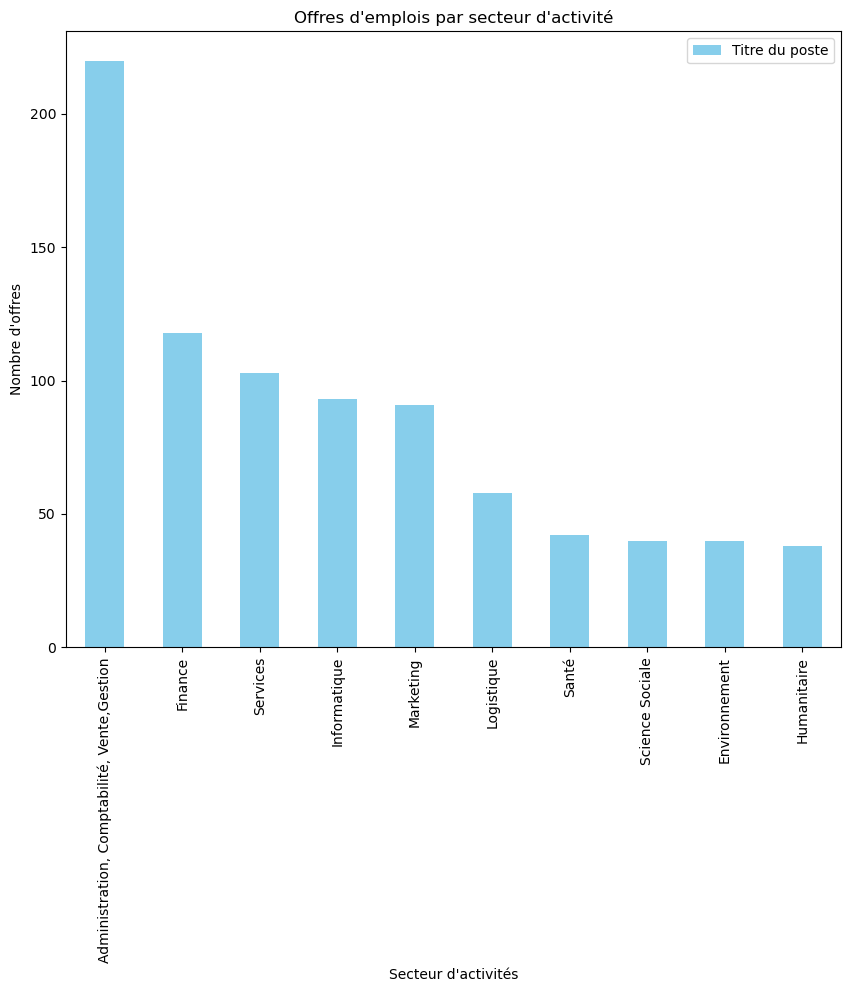

In [27]:
# Offres d'emplois par secteur d'activités
Offres_Catégories.head(10).plot(kind ="bar",figsize = (10,8),color = "skyblue", title ="Offres d\'emplois par secteur d\'activité")
plt.xlabel('Secteur d\'activités')
plt.ylabel('Nombre d\'offres')
plt.show ()

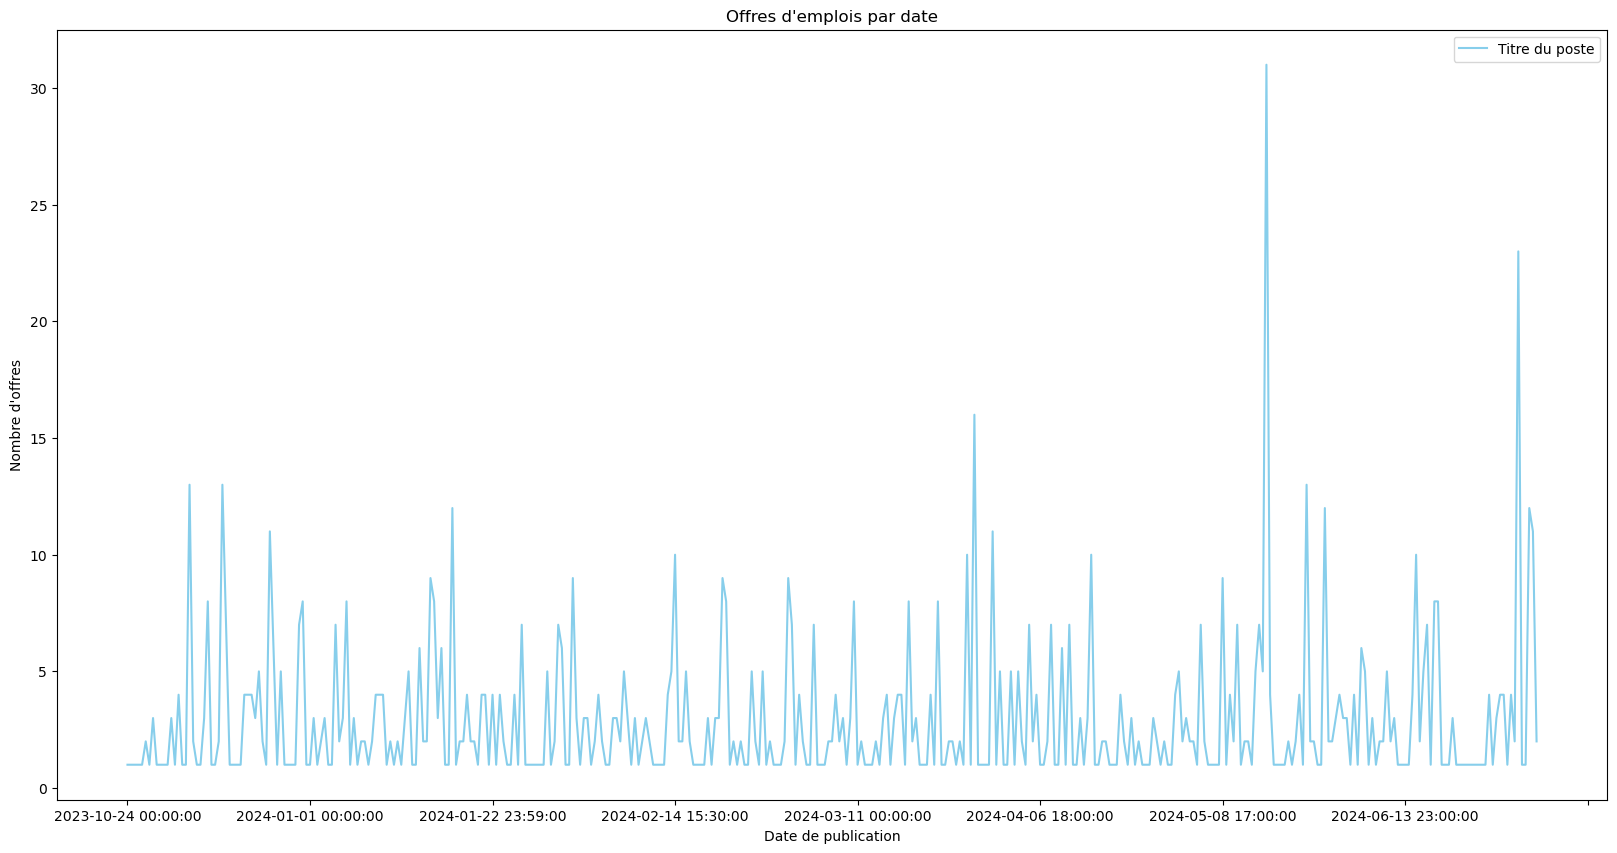

In [28]:
# Offres d'emplois par Date
Offres_Date.plot(kind ="line",figsize = (20,10),color = "skyblue", title ="Offres d\'emplois par date")
plt.xlabel('Date de publication')
plt.ylabel('Nombre d\'offres')
plt.show ()

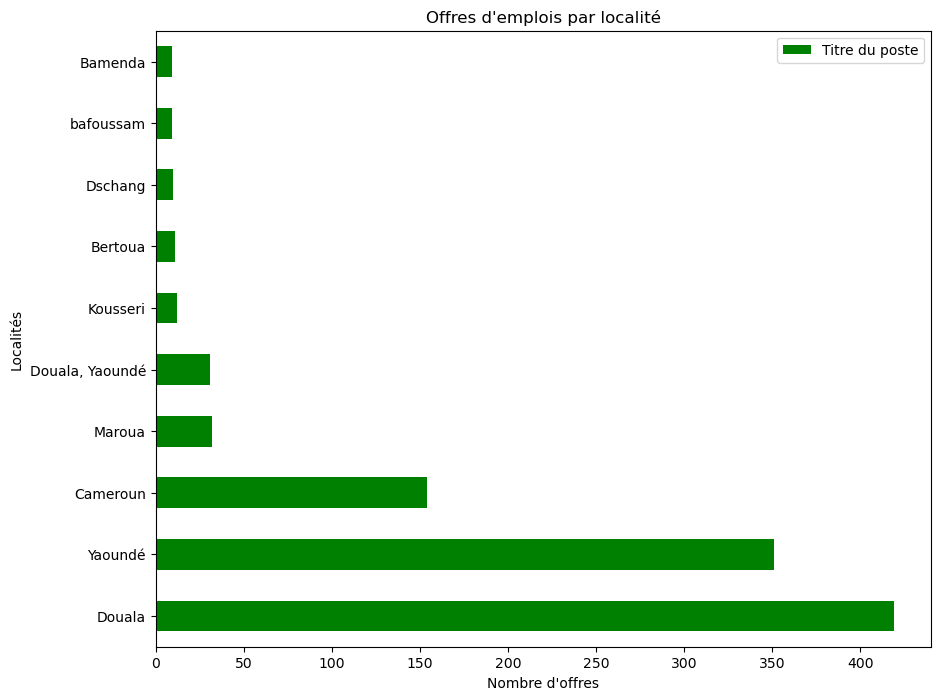

In [29]:
Offres_Localisation.head(10).plot(kind ="barh",figsize = (10,8),color = "green", title ="Offres d\'emplois par localité")
plt.xlabel('Nombre d\'offres')
plt.ylabel('Localités')
plt.show ()

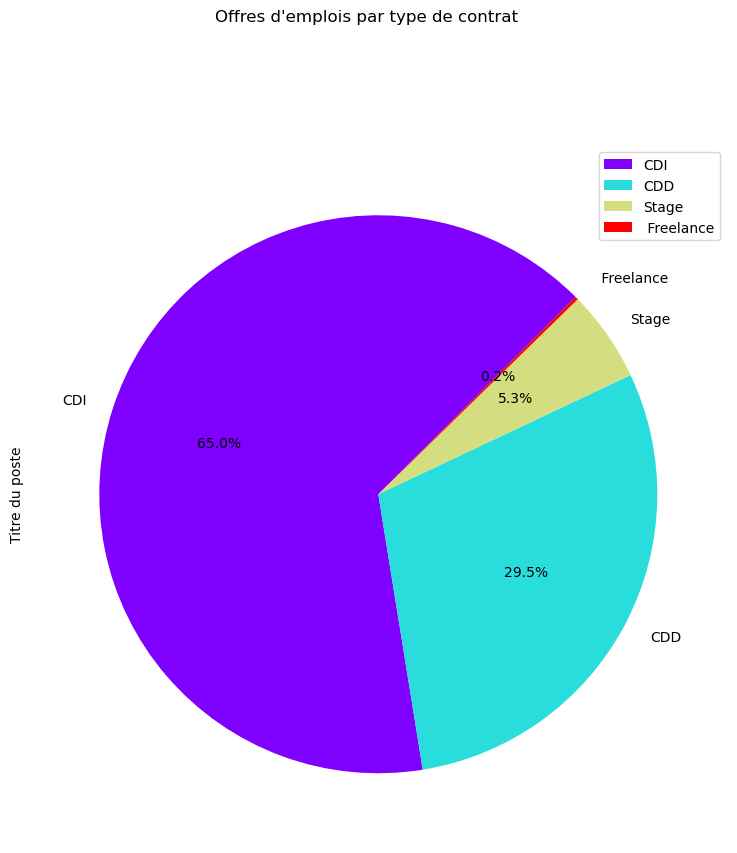

In [30]:
Offres_contrat.plot(kind ="pie",subplots=True,autopct='%1.1f%%', startangle = 45, cmap = "rainbow",figsize = (9,10), title ="Offres d\'emplois par type de contrat")
plt.show ()

In [ ]:
Offres_Entreprise.head(10).plot(kind ="pie",subplots=True,autopct='%1.1f%%', startangle = 45, cmap = "rainbow",figsize = (15,12), title ="Offres d\'emplois par type de contrat")
plt.show ()

# V. Traitement du langage naturel pour la prédiction

In [31]:
import re

In [32]:
# Utilisation des expressions régulières pour séparer les phrases
def separateur(text):
    pattern = r"[^.;]+[.;]?|[.]"
    sentences = re.findall(pattern, text)
    return sentences

In [33]:
# Appliquer le séparateur à la colonne compétence
df["Compétences"] = df["Compétences"].apply(separateur)

In [34]:
# Fonction de tokenisation
from nltk.tokenize import sent_tokenize
def tokenizer(text):
    sentences = sent_tokenize(text)
    return sentences

In [36]:
# Appliquer la tokenisation de phrases à la colonne compétence
#df["Compétences"] = df["Compétences"].apply(tokenizer)

In [41]:
# Initialiser le lemmatizer et les stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('french','english'))

# Fonction de prétraitement
def preprocess_text(text):
    #text = text.lower()  # Convertir en minuscules
    text = ''.join([char for char in text if char not in stop_words])  # Supprimer la ponctuation
    words = text.split()  # Diviser en mots
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatisation et suppression des stopwords
    return ' '.join(words)

In [42]:
# Appliquer le prétraitement aux Compétences
df["Compétences_lem"] = df["Compétences"].apply(preprocess_text)
df["Compétences_lem"]

0                                                  Aucune
1                     Offre disponible personnes majeures
2                                                  Aucune
3       Excellentes qualités relationnelles capacité c...
4       ·; Avoir expérience minimum domaine;', '·; Bon...
                              ...                        
1128                                               Aucune
1129    La modélisation, développement Back-end projet...
1130               . Objectif semaine : 01 vente minimum.
1131    A detail oriented, organized . Working closely...
1132    Produce high quality content & incorporate SEO...
Name: Compétences_lem, Length: 1133, dtype: object

In [ ]:
# Appliquer le prétraitement aux Diplômes
#df["Formation"] = df["Formation"].apply(preprocess_text)

In [ ]:
#categories = [["Administration, Comptabilité, Vente,Gestion","Finance","Services","Informatique","Marketing","Logistique","Santé","Environnement","Science Sociale","Humanitaire","RH","Communication","Industrie","Audit","Télécommunications","Tous les Profils","Agronomie","Droit","Electricité","Economie","Mécanique","BTP","Enseignement","Assurance","Agro-Alimentaire","Biochimie","Comptabilité","Mathématiques","sécurité","Electronique","Froid et Climatisation","Projet","Chimie","Hydraulique","Electromécanique","Biologie","Transport","Sciences Politiques","Plomberie","Pharmacie","Foresterie"]]

In [43]:
# Encodage de la colonne "Secteur d'activité"
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder = LabelEncoder ()
df["Secteur d'activité_encoded"]= encoder.fit_transform(df[["Secteur d'activité"]])
df["Secteur d'activité_encoded"]

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0       24
1        0
2        0
3        0
4        0
        ..
1128    36
1129    36
1130    36
1131    36
1132    36
Name: Secteur d'activité_encoded, Length: 1133, dtype: int32

In [73]:
# Vectorisation des compétences
vectorizer = CountVectorizer()
X = df["Compétences_lem"]
X_vect = vectorizer.fit_transform(X)
X_vect

<1133x6555 sparse matrix of type '<class 'numpy.int64'>'
	with 38781 stored elements in Compressed Sparse Row format>

In [74]:
# Encodage des compétences
#encoder_competence = OneHotEncoder(handle_unknown='ignore')
#X_encoded = encoder_competence.fit_transform(X).reshape(1,-1)

In [75]:
# Subdivision des données
X = X_vect
y = df['Secteur d\'activité_encoded']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 

In [76]:
#from sklearn.linear_model import LinearRegression

In [77]:
from sklearn.tree import DecisionTreeClassifier

In [78]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
# Construction des modeles
modelDT = DecisionTreeClassifier()
modelRFR = RandomForestRegressor ()
modelNB = MultinomialNB()
model_knn = KNeighborsClassifier(5)
model_svm=SVC(kernel='linear')

In [82]:
modelDT.fit(X_train, y_train)
modelRFR.fit(X_train, y_train)
modelNB.fit(X_train, y_train)
#modelLR.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_svm.fit(X_train, y_train)

SVC(kernel='linear')

In [83]:
# Prédictions
y_predDT = modelDT.predict(X_test)
y_predRFR = modelRFR.predict(X_test)
#y_predLR = modelLR.predict(X_test)
y_predNB = modelNB.predict(X_test)
y_predKNN = model_knn.predict(X_test)
y_predSVM = model_svm.predict(X_test)

In [84]:
# Matrice de confusion
conf_matrixDT = confusion_matrix(y_test, y_predDT)
#conf_matrixRFR = confusion_matrix(y_test, y_predRFR)
conf_matrixNB = confusion_matrix(y_test, y_predNB)
conf_matrixKNN= confusion_matrix(y_test, y_predKNN)
conf_matrixSVM= confusion_matrix(y_test, y_predSVM)

#print("Matrice de confusion pour RFR :\n", conf_matrixRFR)
print("Matrice de confusion pour NB :\n", conf_matrixNB)
print("Matrice de confusion pour KNN :\n", conf_matrixKNN)
print("Matrice de confusion pour SVM :\n", conf_matrixSVM)

Matrice de confusion pour NB :
 [[34  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Matrice de confusion pour KNN :
 [[14  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 3  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]]
Matrice de confusion pour SVM :
 [[23  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 1  0  0 ...  0  0  0]
 [ 4  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


NameError: name 'conf_matrixRFR' is not defined

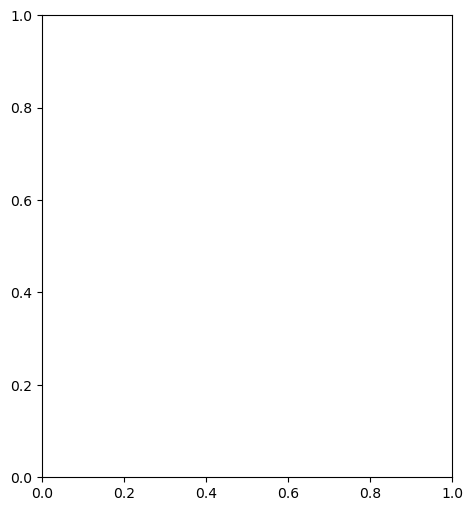

In [85]:
# Génération des graphiques
plt.figure(figsize=(18, 6))

# Matrice de confusion pour la Régression Linéaire
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrixRFR, annot=True, cmap="Greens")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - Random Forest Regressor')

# Matrice de confusion pour Naive Bayes
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrixNB, annot=True, cmap="Greens")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - Naive Bayes')

# Matrice de confusion pour k-NN
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrixKNN, annot=True, cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - k-NN')

# Matrice de confusion pour SVM
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrixSVM, annot=True, cmap="Reds")
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion - SVM')

# Affichage des graphiques
plt.tight_layout()
plt.savefig('matrices_confusion.png')
plt.show()

In [86]:
# Calcul des rapports de classification pour chaque modèle
reportDT = classification_report(y_test, y_predDT, output_dict=True)
#reportRFR = classification_report(y_test, y_predRFR, output_dict=True)
reportNB = classification_report(y_test, y_predNB, output_dict=True)
reportKNN = classification_report(y_test, y_predKNN, output_dict=True)
reportSVM = classification_report(y_test, y_predSVM, output_dict=True)

# Création des DataFrames à partir des rapports de classification
df_report = pd.DataFrame({
    'Modèle': ['Decision Tree','Naive Bayes','k-NN', 'SVM'],
    'Précision': [reportDT['weighted avg']['precision'],reportNB['weighted avg']['precision'], reportKNN['weighted avg']['precision'], reportSVM['weighted avg']['precision']],
    'Rappel': [reportDT['weighted avg']['recall'],reportNB['weighted avg']['recall'], reportKNN['weighted avg']['recall'], reportSVM['weighted avg']['recall']],
    'F1-score': [reportDT['weighted avg']['f1-score'],reportNB['weighted avg']['f1-score'], reportKNN['weighted avg']['f1-score'], reportSVM['weighted avg']['f1-score']]
})
df_report

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.

,Modèle,Précision,Rappel,F1-score
0,Decision Tree,0.202430,0.202643,0.185508
1,Naive Bayes,0.238544,0.246696,0.181020
2,k-NN,0.097688,0.101322,0.084932
3,SVM,0.150540,0.193833,0.154165


In [87]:
# Précision du random forest regressor
modelRFR.score(X_test, y_test)

-0.043471455483186094

## V. Optimisation des modèles utilisés

In [88]:
from sklearn.preprocessing import MaxAbsScaler

In [89]:
# Normalisation des données
scaler = MaxAbsScaler ()
X_train_nor= scaler.fit_transform(X_train)
X_test_nor= scaler.fit_transform(X_test)

### 1. Random Search

In [90]:
# Importation de l'algorithme
from sklearn.model_selection import RandomizedSearchCV

In [91]:
# Définition de la distribution des hyperparamètres à tester
from scipy.stats import randint
param_dist = {
    'n_neighbors':randint(1,40),
    'metric':['euclidean','manhattan','chebyshev']
}

In [92]:
# Configuration de Random Search
Random_search = RandomizedSearchCV (model_knn,param_dist, n_iter = 50, cv = 5, random_state = 42)

In [93]:
# Entrainement du modèle avec Random Search
Random_search.fit(X_train_nor,y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000222DB108DD0>},
                   random_state=42)

In [94]:
# Affichage des meilleurs paramètres
print ("Meilleurs paramètres (Random Search):", Random_search.best_params_)

Meilleurs paramètres (Random Search): {'metric': 'manhattan', 'n_neighbors': 29}


In [95]:
# Evaluation du modèle
from sklearn.metrics import accuracy_score
y_pred = Random_search.fit(X_test_nor)
accuracy_random = accuracy_score(y_test, y_pred)
print ("Précision(Random Search):",accuracy_random)

ValueError: 
All the 250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: KNeighborsClassifier.fit() missing 1 required positional argument: 'y'


### 2.Grid search

In [96]:
# Importation de l'algorithme
from sklearn.model_selection import GridSearchCV

In [97]:
# Définition de la grille des hyperparamètres du modèle
param_grid = {
    'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23,25],
    'metric':['euclidean','manhattan']
}

In [98]:
# Configuration de Grid Search
grid_search = GridSearchCV (model_knn,param_grid, cv =5)

In [99]:
# Entrainement du modèle avec Grid Search
grid_search.fit(X_train_nor,y_train)

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25]})

In [100]:
# Affichage des meilleurs paramètres
print ("Meilleurs paramètres de KNN (Grid Search):", grid_search.best_params_)

Meilleurs paramètres de KNN (Grid Search): {'metric': 'euclidean', 'n_neighbors': 25}


In [101]:
# Evaluation des modèles
y_pred = grid_search.predict(X_test_nor)
accuracy_grid = accuracy_score(y_test, y_pred)
print ("Précision (Grid Search):",accuracy_grid)

Précision (Grid Search): 0.1762114537444934


### 3. Optimisation par validation croisée

In [102]:
# Importation de l'algorithme
from sklearn.model_selection import cross_val_score

In [104]:
# Entraînement de l'algorithme d'optimisation
scores_valKNN = cross_val_score (model_knn,X_train,y_train, cv =5)
print("Scores de validation croisée avec KNN:", scores_valKNN)
print("précision moyenne de KNN :%0.2f (+/- %0.2f)" % (scores_valKNN.mean(), scores_valKNN.std()*2))

scores_valSVM = cross_val_score (model_svm,X_train,y_train, cv =5)
print("Scores de validation croisée avec SVM:", scores_valSVM)
print("précision moyenne de SVM :%0.2f (+/- %0.2f)" % (scores_valSVM.mean(), scores_valSVM.std()*2))

scores_valDT = cross_val_score (modelDT,X_train,y_train, cv =5)
print("Scores de validation croisée avec DT:", scores_valDT)
print("précision moyenne de DT :%0.2f (+/- %0.2f)" % (scores_valDT.mean(), scores_valDT.std()*2))

scores_valRFR = cross_val_score (modelRFR,X_train,y_train, cv =5)
print("Scores de validation croisée avec RFR:", scores_valRFR)
print("précision moyenne de RFR :%0.2f (+/- %0.2f)" % (scores_valRFR.mean(), scores_valRFR.std()*2))

scores_valNB = cross_val_score (modelNB,X_train,y_train, cv =5)
print("Scores de validation croisée avec NB:", scores_valNB)
print("précision moyenne de NB :%0.2f (+/- %0.2f)" % (scores_valNB.mean(), scores_valNB.std()*2))

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Scores de validation croisée avec KNN: [0.1978022  0.16022099 0.16022099 0.1878453  0.14364641]
précision moyenne de KNN :0.17 (+/- 0.04)
Scores de validation croisée avec SVM: [0.24175824 0.27624309 0.20441989 0.24309392 0.22099448]
précision moyenne de SVM :0.24 (+/- 0.05)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Scores de validation croisée avec DT: [0.26923077 0.22651934 0.22651934 0.20994475 0.25414365]
précision moyenne de DT :0.24 (+/- 0.04)
Scores de validation croisée avec RFR: [ 0.03623708 -0.01342607 -0.13431903 -0.04891152  0.1170639 ]
précision moyenne de RFR :-0.01 (+/- 0.17)
Scores de validation croisée avec NB: [0.27472527 0.25414365 0.23756906 0.25414365 0.28176796]
précision moyenne de NB :0.26 (+/- 0.03)


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
